In [3]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [5]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [6]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


43950080/43941136 [==============================] - 2s 0us/step


2022/03/17 16:55:26 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB3 con DataAugmentation (ImageNet)' does not exist. Creating a new experiment.


Epoch 1/25
257/257 [==============================] - 117s 333ms/step - loss: 2.5046 - accuracy: 0.5519 - val_loss: 1.3926 - val_accuracy: 0.6016
Epoch 2/25
257/257 [==============================] - 81s 314ms/step - loss: 1.5254 - accuracy: 0.6588 - val_loss: 1.1940 - val_accuracy: 0.6693
Epoch 3/25
257/257 [==============================] - 81s 314ms/step - loss: 1.1334 - accuracy: 0.6915 - val_loss: 1.0978 - val_accuracy: 0.7043
Epoch 4/25
257/257 [==============================] - 81s 314ms/step - loss: 1.0152 - accuracy: 0.7129 - val_loss: 0.9787 - val_accuracy: 0.7228
Epoch 5/25
257/257 [==============================] - 81s 314ms/step - loss: 0.9400 - accuracy: 0.7169 - val_loss: 0.9849 - val_accuracy: 0.7063
Epoch 6/25
257/257 [==============================] - 81s 314ms/step - loss: 0.8893 - accuracy: 0.7263 - val_loss: 0.9229 - val_accuracy: 0.7272
Epoch 7/25
257/257 [==============================] - 81s 313ms/step - loss: 0.8984 - accuracy: 0.7268 - val_loss: 1.0516 - val_a

2022/03/17 17:08:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


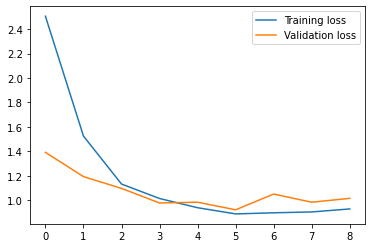

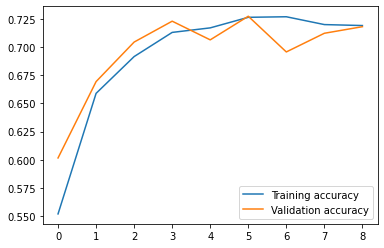

In [7]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Vamos a entrenar usando la red EfficietNetB3
base_model = tf.keras.applications.EfficientNetB3(include_top=False,
                                                  weights='imagenet',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=1e-2)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB3 con DataAugmentation (ImageNet)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/20
257/257 [==============================] - 320s 1s/step - loss: 1.5678 - accuracy: 0.5913 - val_loss: 1.9227 - val_accuracy: 0.4910
Epoch 2/20
257/257 [==============================] - 296s 1s/step - loss: 0.6716 - accuracy: 0.7930 - val_loss: 0.5132 - val_accuracy: 0.8359
Epoch 3/20
257/257 [==============================] - 296s 1s/step - loss: 0.4450 - accuracy: 0.8539 - val_loss: 0.4414 - val_accuracy: 0.8587
Epoch 4/20
257/257 [==============================] - 295s 1s/step - loss: 0.3428 - accuracy: 0.8848 - val_loss: 0.4314 - val_accuracy: 0.8729
Epoch 5/20
257/257 [==============================] - 295s 1s/step - loss: 0.2705 - accuracy: 0.9081 - val_loss: 0.4068 - val_accuracy: 0.8729
Epoch 6/20
257/257 [==============================] - 296s 1s/step - loss: 0.2059 - accuracy: 0.9278 - val_loss: 0.4544 - val_accuracy: 0.8719
Epoch 7/20
257/257 [==============================] - 295s 1s/step - loss: 0.1834 - accuracy: 0.9345 - val_loss: 0.3829 - val_accuracy: 0.8914

2022/03/17 18:01:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


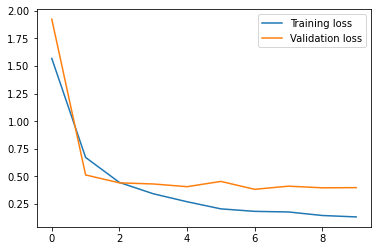

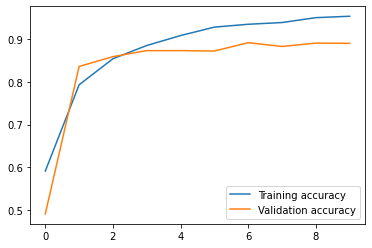

In [8]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=20,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [9]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [10]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB3_ImageNet_No_DataAugmentation.csv', index=False)
files.download('EfficientNetB3_ImageNet_No_DataAugmentation.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>